In [16]:
# -------- Imports --------
import sys
import os
import numpy as np
import scipy.sparse as sp
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
from _utility import *


In [17]:
# -------- Parameters --------
# -- Grid parameters --
Nx, Ny  = 200, 200
dx, dy = 1.0, 1.0
psi_len = Nx*Ny + (Nx-1)*Ny + Nx*(Ny-1) # Number of values for the staggered grid

# -- Simulation parameters --
Nt = 100
dt = 3.0


In [18]:
# -- Source region parameters (Example: Homogeneous) --
# Velocity (c)
c0_S = 3

# Density (rho)
rho0_S = 2

# -- Point source function --
t_span = (0, 10.0)          # Source activation time span
f0 = 0.2                    # Central frequency of the Ricker wavelet
A = 10.0                    # Amplitude of the source
S0 = lambda t: Ricker(f0, t, 0, 0, x0=5) * A
S_u, S_vx, S_vy = compute_source_2D(S0, t_span, dx, dy, c0_S, rho0_S)
Sn_x, Sn_y = S_u.shape


In [19]:
# -- Wave field definition --
# -- Material properties --
# Velocity (c)
c0 = 3
c_model = c0 * np.ones((Ny, Nx))

# Density (rho)
rho0 = 2
rho_model = rho0 * np.ones((Ny, Nx))
rho_stag_x = rho0 * np.ones((Ny, (Nx-1)))
rho_stag_y = rho0 * np.ones(((Ny-1), Nx))

# -------- Simulation (2D Acoustic) --------
(H, _, _, B_sqrt, _, B_inv_sqrt) = FD_solver_2D(Nx, Ny, dx, dy, c_model, rho_model, rho_stag_x, rho_stag_y)


In [20]:
# -------- Multi-Simulation --------
# Define the time span for the sources
t_span_A = (0, 10.0)       # Time span for source A
t_span_B = (10.0, 20.0)    # Time span for source B
t_sync = max(t_span_A[1], t_span_B[1])

# Define material properties for the global model
B_sqrt_mult = sp.block_diag([B_sqrt, B_sqrt])
B_inv_sqrt_mult = sp.block_diag([B_inv_sqrt, B_inv_sqrt])

# Define the synchronization Hamiltonian
H_sync = sp.block_diag([(t_sync-t_span_A[1])*H, (t_sync-t_span_B[1])*H])

# Define the global evolution Hamiltonian
H_mult = sp.block_diag([H, H])

# Source A (Global time span: 0-10)
Sx0_A, Sy0_A = 30, 30      # Define the center of source A in the global model
u0_A = np.zeros((Ny, Nx))
v0x_A = np.zeros((Ny, (Nx-1)))
v0y_A = np.zeros(((Ny-1), Nx))
u0_A[Sx0_A-Sn_x//2:Sx0_A+Sn_x//2, Sy0_A-Sn_y//2:Sy0_A+Sn_y//2] = S_u
v0x_A[Sx0_A-Sn_x//2:Sx0_A+Sn_x//2, Sy0_A-Sn_y//2:Sy0_A+Sn_y//2-1] = S_vx
v0y_A[Sx0_A-Sn_x//2:Sx0_A+Sn_x//2-1, Sy0_A-Sn_y//2:Sy0_A+Sn_y//2] = S_vy

# Source B (Global time span: 10-20)
Sx0_B, Sy0_B = 100, 100     # Define the center of source B in the global model
u0_B = np.zeros((Ny, Nx))
v0x_B = np.zeros((Ny, (Nx-1)))
v0y_B = np.zeros(((Ny-1), Nx))
u0_B[Sx0_B-Sn_x//2:Sx0_B+Sn_x//2, Sy0_B-Sn_y//2:Sy0_B+Sn_y//2] = S_u
v0x_B[Sx0_B-Sn_x//2:Sx0_B+Sn_x//2, Sy0_B-Sn_y//2:Sy0_B+Sn_y//2-1] = S_vx
v0y_B[Sx0_B-Sn_x//2:Sx0_B+Sn_x//2-1, Sy0_B-Sn_y//2:Sy0_B+Sn_y//2] = S_vy


In [21]:
# -------- Initial State  --------
# Stack the initial conditions
phi_0 = np.hstack([u0_A.flatten(), v0x_A.flatten(), v0y_A.flatten(),
                   u0_B.flatten(), v0x_B.flatten(), v0y_B.flatten()])

# Normalize the initial state and transform it to the energy basis
psi_0 = B_sqrt_mult @ phi_0
norm = np.linalg.norm(psi_0)
psi_0 /= norm


In [22]:
# -------- Time Evolution --------
# Syncronize the states (energy basis)
psi_sync = sp.linalg.expm_multiply(-1j * H_sync, psi_0, start=0, stop=1, num=2, endpoint=False).real

# Evolve the multi-state over time (energy basis)
psi_t = sp.linalg.expm_multiply(-1j * H_mult, psi_sync[-1], start=0, stop=Nt*dt-t_sync, num=Nt, endpoint=True).real


In [23]:
# -------- Final State --------
# Transform the state back to the original basis
phi_t = norm * (B_inv_sqrt_mult @ psi_t.T).T


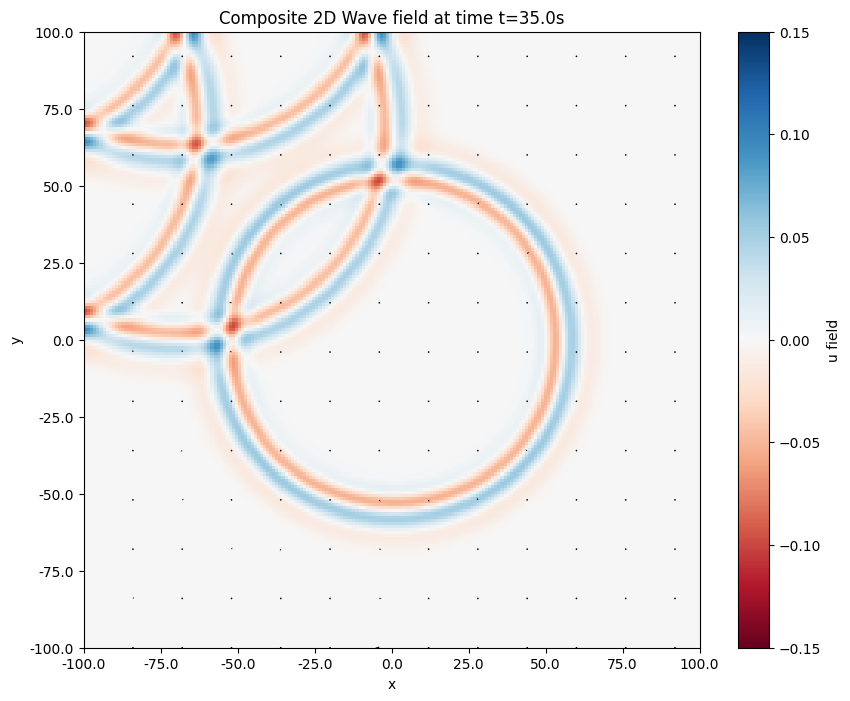

In [24]:
# -------- Plot --------
t_plot = 5

# Sum the composite fields (linear superposition)
phi_t_sum = phi_t[t_plot].reshape(2, -1).sum(axis=0)

# Plot the composite field
plot_acoustic_2D(phi_t_sum, Nx, Ny, dx, dy, title=f'Composite 2D Wave field at time t={t_plot*dt + t_sync}s')
